# Necessary installs: run them only once, then restart kernel

In [2]:
#pip install asyncio

In [3]:
#pip install bootstrap-stat

In [4]:
#pip install --upgrade scipy

# Imports

In [1]:
import pandas as pd
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, bootstrap
import statsmodels.api as sm
import seaborn as sns
import itertools
import random
from sympy.combinatorics import GrayCode
from multiprocessing import Process, Pool
from joblib import Parallel, delayed
import tqdm

In [2]:
random.seed(42) ### setting a random seed for reproducible results

In [3]:
from bootstrap_stat import bootstrap_stat as bp
from bootstrap_stat import datasets as d

In [5]:
df = d.law_data()
df ###dataframe containing all 15 datapoints

,LSAT,GPA
0,576,3.39
1,635,3.30
2,558,2.81
3,578,3.03
4,666,3.44
5,580,3.07
6,555,3.00
7,661,3.43
8,651,3.36
9,605,3.13


In [7]:
df.describe() ###basic statistics for the data

,LSAT,GPA
count,15.000000,15.000000
mean,600.266667,3.094667
std,41.794509,0.243512
min,545.000000,2.740000
25%,573.500000,2.920000
50%,580.000000,3.070000
75%,643.000000,3.330000
max,666.000000,3.440000


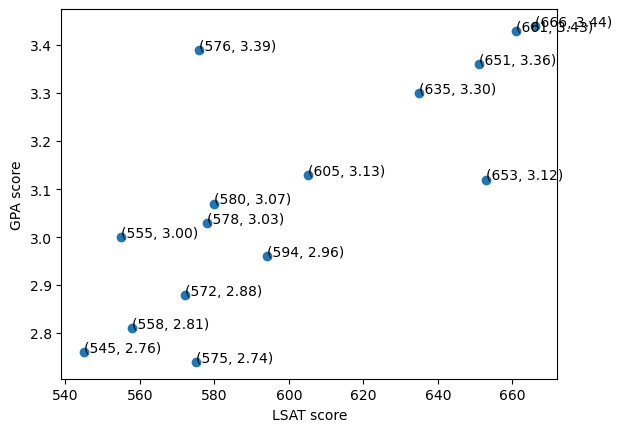

In [8]:
### Plotting the points

fig = plt.figure()
ax = fig.add_subplot(111)
x = df['LSAT']
y = df['GPA']

ax.scatter(x, y)
ax.set_xlabel("LSAT score")
ax.set_ylabel("GPA score")
for xy in zip(x, y):
    plt.annotate('(%.0f, %.2f)' % xy, xy=xy)
plt.show()

In [9]:
### Pearson's r correlation coefficient for the whole n=15 points

pearsonr(df['LSAT'], df['GPA'])

PearsonRResult(statistic=0.776374491289407, pvalue=0.0006651020111028157)

In [11]:
### Spearsman's r for reference and comparison

spearmanr(df['LSAT'], df['GPA'])

SignificanceResult(statistic=0.7964285714285713, pvalue=0.00038046767853463354)

In [12]:
df

,LSAT,GPA
0,576,3.39
1,635,3.30
2,558,2.81
3,578,3.03
4,666,3.44
5,580,3.07
6,555,3.00
7,661,3.43
8,651,3.36
9,605,3.13


# Bootstrap for B=40000 for complete (n=15) dataset

In [13]:
A = df.to_numpy() ### A is a copy of df, used for random sampling in the bootstrap
print(A.shape)

(15, 2)


In [14]:
### This cell contains the loop that calculates the pearson's r coefficient distribution for the bootstrap


start = time.time()
boot_r = [] ### boot r contains all the 40,000 results for the bootstrap
boot_p_val=[]
n_resamples = 40000
for i in range(n_resamples):
    boot_sample = A[np.random.choice(A.shape[0], A.shape[0], replace=True)] ### random sampling with replacement
    boot_r_temp, boot_p_val_temp = pearsonr(boot_sample[:,0], boot_sample[:,1])
    boot_r.append(boot_r_temp)
    boot_p_val.append(boot_p_val_temp)
    
end = time.time()

print(f"The time to run the bootstrap for {n_resamples} number of samples was: {end-start} seconds\n")
print(f"The mean of this distribution is:{np.mean(boot_r)}")


The time to run the bootstrap for 40000 number of samples was: 41.73664617538452 seconds

The mean of this distribution is:0.7701965395402364


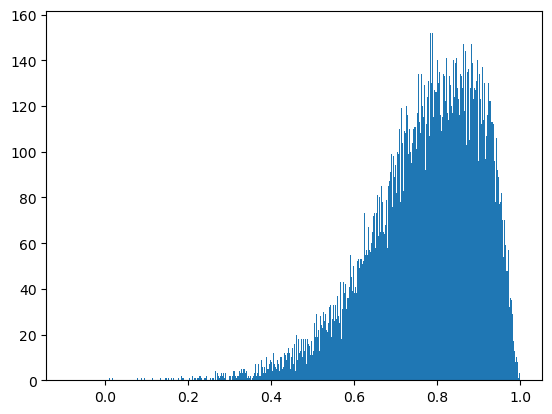

In [15]:
plt.hist(boot_r, bins=1000)
plt.show()

# The distribution of the bootstrap r is shown below

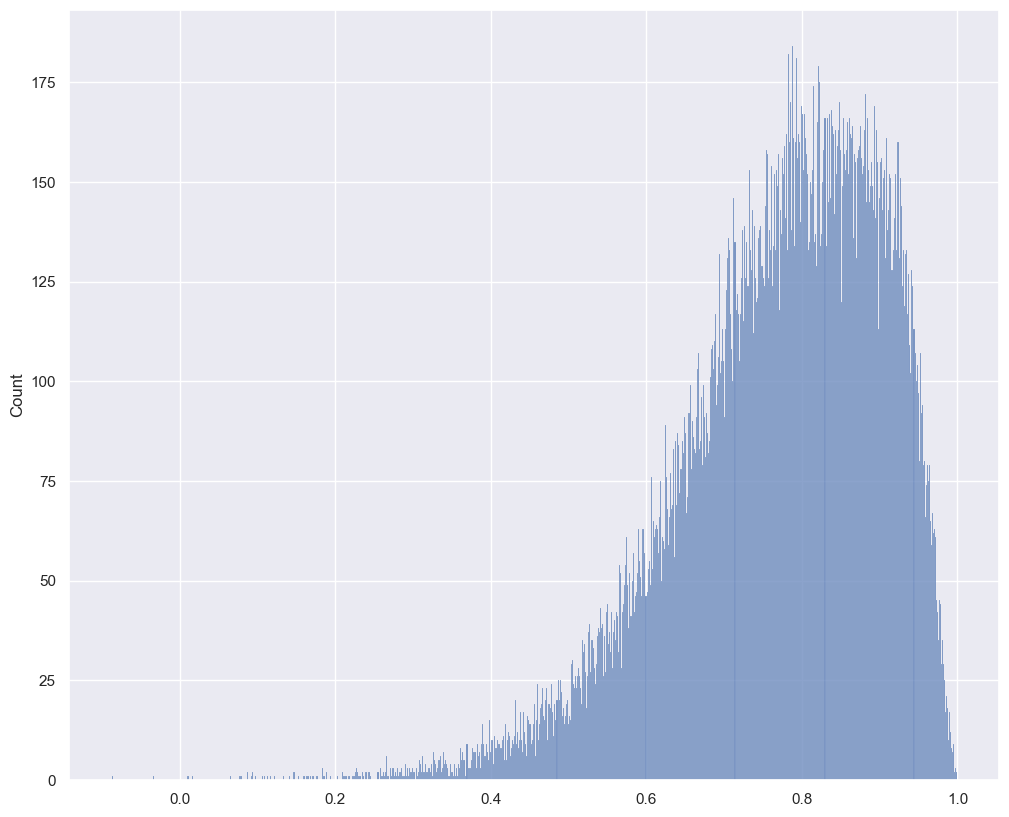

In [16]:
sns.set(rc={"figure.figsize":(12,10)})
sns.histplot(boot_r, binwidth=0.0013)
plt.show()

# Deleting some points for faster computations

# Bootstrap for B=40000 for n=11 points

In [17]:
df

,LSAT,GPA
0,576,3.39
1,635,3.30
2,558,2.81
3,578,3.03
4,666,3.44
5,580,3.07
6,555,3.00
7,661,3.43
8,651,3.36
9,605,3.13


In [18]:
df_t=df.drop([df.index[2], df.index[7],df.index[8], df.index[13]])

In [20]:
df_t ### contains 11 points, so 15 minus 4 highly correlated points in order to not change the distribution too much and also to see the effect of outliers in the end

,LSAT,GPA
0,576,3.39
1,635,3.30
3,578,3.03
4,666,3.44
5,580,3.07
6,555,3.00
9,605,3.13
10,653,3.12
11,575,2.74
12,545,2.76


In [21]:
A_11 = df_t.to_numpy()
print(A_11.shape)

(11, 2)


In [22]:
start = time.time()
boot_r_11 = []
boot_p_val_11=[]
n_resamples = 40000
for i in range(n_resamples):
    boot_sample_11 = A_11[np.random.choice(A_11.shape[0], 11, replace=True)]
    boot_r_temp_11, boot_p_val_temp_11 = pearsonr(boot_sample_11[:,0], boot_sample_11[:,1])
    boot_r_11.append(boot_r_temp_11)
    boot_p_val_11.append(boot_p_val_temp_11)
    
end = time.time()

print(f"The time to run the bootstrap for {n_resamples} number of samples was: {end-start} seconds ")
# plt.hist(boot_r_11, bins=100)
# plt.show()

The time to run the bootstrap for 40000 number of samples was: 41.84997606277466 seconds 


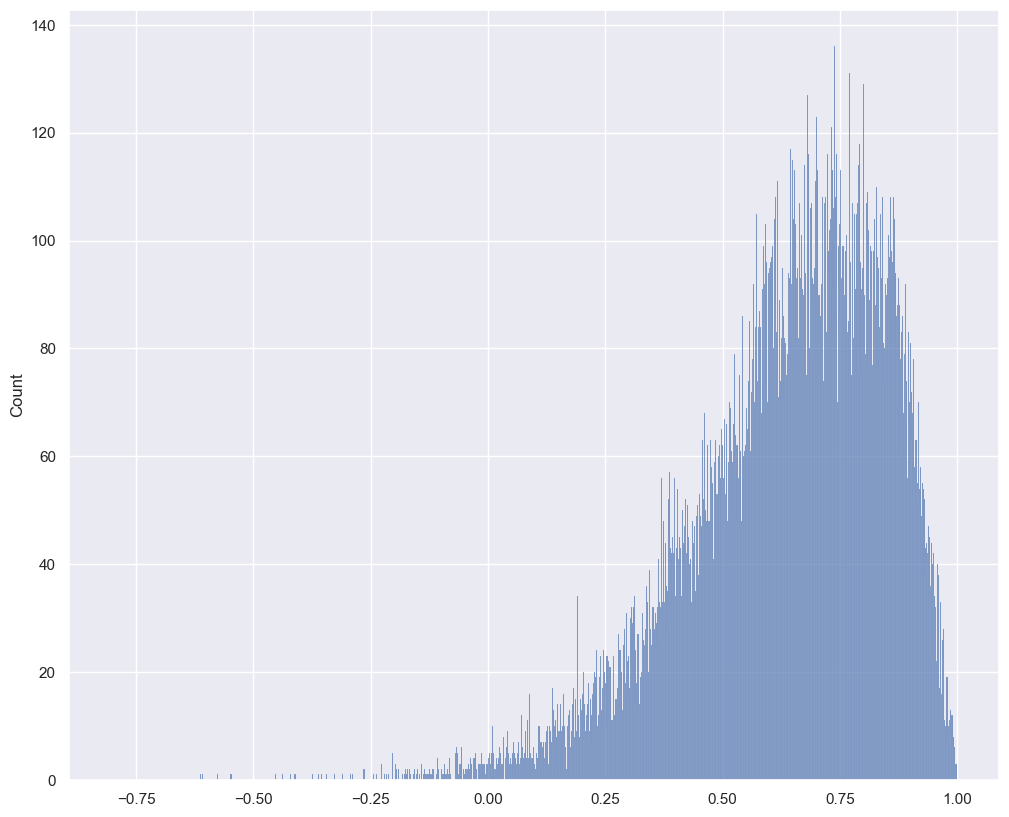

In [23]:
sns.set(rc={"figure.figsize":(12,10)})
sns.histplot(boot_r_11, binwidth=0.0013)
plt.show()

In [24]:
np.nanmean(boot_r_11) ### np.nanmean since if some values are nan, the normal np.mean function produces an error 

0.637153876473469

# Complete Enumeration without Gray Codes for n=11 (for faster computations)
## 4 highly correlated points were removed from the original 15 

In [25]:
l = [0,1,2,3,4,5,6,7,8,9,10] ### indexes for our dataframe containing the n=11 points
combinations = list(itertools.combinations_with_replacement(l,11)) ### all possible combinations with replacement of 11 points as indexes

In [26]:
df_copy = df_t.reset_index(drop=True)

In [27]:
df_copy

,LSAT,GPA
0,576,3.39
1,635,3.30
2,578,3.03
3,666,3.44
4,580,3.07
5,555,3.00
6,605,3.13
7,653,3.12
8,575,2.74
9,545,2.76


In [28]:
type(list(combinations[5698]))

list

In [29]:
ls = list(combinations[0])
print(ls)
sample = df_copy.iloc[ls]
sample ### for example the first sample contains only the first datapoint (index 0 ) 11 times

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


,LSAT,GPA
0,576,3.39
0,576,3.39
0,576,3.39
0,576,3.39
0,576,3.39
0,576,3.39
0,576,3.39
0,576,3.39
0,576,3.39
0,576,3.39


In [30]:
len(combinations) ### how many possible combinations with replacement there are for n=11. 
### For sanity check on n=11: (2n-1)C(n-1) 21C10=352716

352716

In [31]:
index = np.arange(len(combinations))
type(index)

numpy.ndarray

In [32]:
index = index.tolist()
print(type(index))

<class 'list'>


In [33]:
start = time.time()

complete_r = []

for k, i in zip(combinations, index):
    ls = list(k)
    sample = df_copy.iloc[ls].to_numpy()
    temp_r, _ = pearsonr(sample[:,0], sample[:,1])
    complete_r.append(temp_r) 
    if (i%10000 ==0): ### print every 10000 samples to see progress
        print(i)
                    

end = time.time()

print(end-start) ### seconds to run this cell (usually 570 seconds)

C:\Users\Uni\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
501.3257758617401


# Histogram for the full enumeration on n=11 points

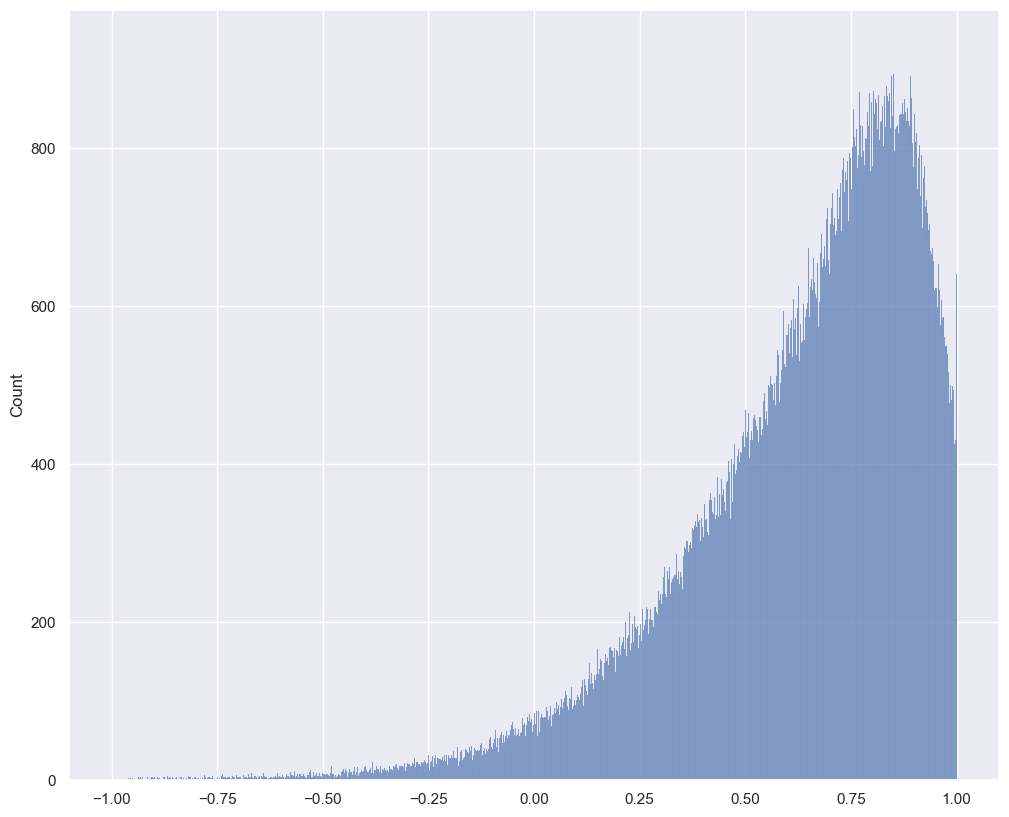

In [36]:
sns.set(rc={"figure.figsize":(12,10)})
sns.histplot(complete_r, binwidth=0.0013)
plt.show()

In [38]:
np.nanmean(complete_r) ### again we calculate the nanmean instead of the mean, because when all data are the same point in a sample, the function returns nan

0.6276445329347745

# Monte Carlo with manual distribution for picking original 11 points (pick the 2 outliers with 0 probability)

In [39]:
### probability vector of picking points

prob_in = 1/9 ###probability of picking one of 9 inliers
prob_out =  0 ### probability of picking one of 2 outliers
p = [prob_out, prob_in, prob_in, prob_in, prob_in, prob_in, prob_in, prob_out, prob_in, prob_in, prob_in]

print(len(p))

np.sum(p) ### sum of probablities of all points has to be 1

11


1.0

In [40]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# x = df_monte['LSAT']
# y = df_monte['GPA']
# ax.scatter(x, y)
# for xy in zip(x, y):
#     plt.annotate('(%.2f, %.2f)' % xy, xy=xy)
# plt.show()

In [41]:
A_monte = df_copy.to_numpy()

In [42]:
start = time.time()
monte_r = []
monte_p_val=[]
n_resamples = 40000
for i in range(n_resamples):
    monte_sample = A_monte[np.random.choice(A_monte.shape[0], 11, replace=True, p=p)]
    monte_r_temp, monte_p_val_temp = pearsonr(monte_sample[:,0], monte_sample[:,1])
    monte_r.append(monte_r_temp)
    monte_p_val.append(monte_p_val_temp)
    
end = time.time()

print(f"The time to run the Monte Carlo simulation for {n_resamples} number of samples with the manual probability distribution was:\n {end-start} seconds ")


The time to run the Monte Carlo simulation for 40000 number of samples with the manual probability distribution was:
 43.901071310043335 seconds 


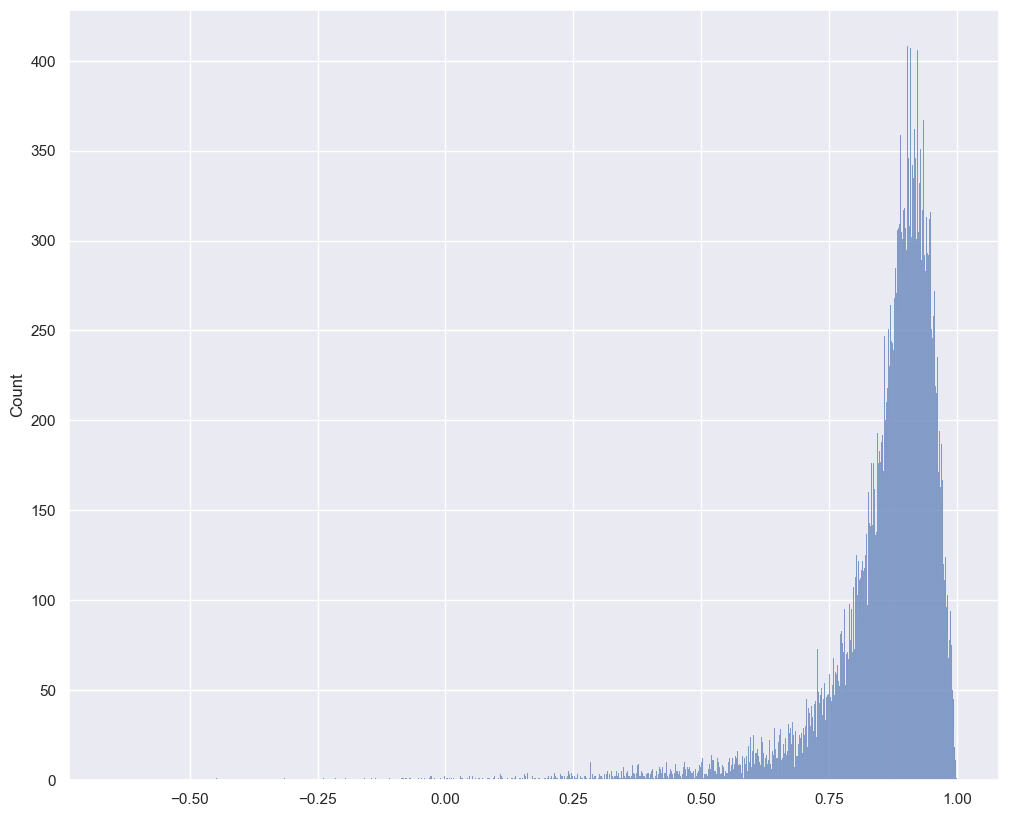

In [43]:
sns.histplot(monte_r, binwidth=0.0013)
plt.show()

In [44]:
np.mean(monte_r) ### mean of distribution is increased when the outliers are not sampled, as was expected

0.8620936046945146

# Monte Carlo with manual distribution for picking original 11 points (pick the 2 outliers with probability 0.05 and inliers with probability 0.1)

In [45]:
### probability vector of picking points

prob_in_2 = 0.1 ###probability of picking one of 9 inliers
prob_out_2 = 0.05 ### probability of picking one of 2 outliers
p_2 = [prob_out_2, prob_in_2, prob_in_2, prob_in_2, prob_in_2, prob_in_2, prob_in_2, prob_out_2, prob_in_2, prob_in_2, prob_in_2]

print(len(p_2))

np.sum(p_2) ### sum of probablities of all points has to be 1

11


1.0

In [46]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# x = df_monte['LSAT']
# y = df_monte['GPA']
# ax.scatter(x, y)
# for xy in zip(x, y):
#     plt.annotate('(%.2f, %.2f)' % xy, xy=xy)
# plt.show()

In [47]:
A_monte_2 = df_copy.to_numpy()

In [48]:
start = time.time()
monte_r_2 = []
monte_p_val_2=[]
n_resamples = 40000
for i in range(n_resamples):
    monte_sample_2 = A_monte_2[np.random.choice(A_monte_2.shape[0], 11, replace=True, p=p_2)]
    monte_r_temp_2, monte_p_val_temp_2 = pearsonr(monte_sample_2[:,0], monte_sample_2[:,1])
    monte_r_2.append(monte_r_temp_2)
    monte_p_val_2.append(monte_p_val_temp_2)
    
end = time.time()

print(f"The time to run the Monte Carlo simulation for {n_resamples} number of samples with the manual probability distribution was:\n {end-start} seconds ")


The time to run the Monte Carlo simulation for 40000 number of samples with the manual probability distribution was:
 44.14205312728882 seconds 


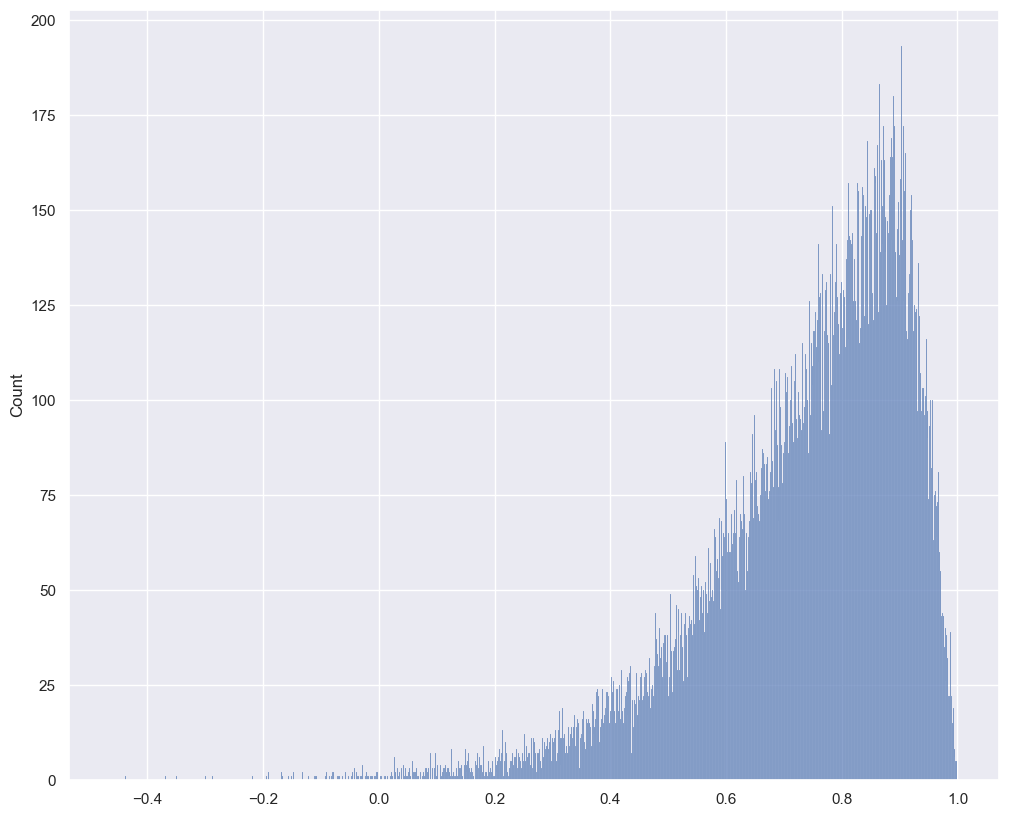

In [49]:
sns.histplot(monte_r_2, binwidth=0.0013)
plt.show()

In [50]:
np.mean(monte_r_2) ### mean of distribution is increased when the outliers are less probable to be sampled in each sample

0.7396940184977582

### The mean of the distribution is higher when the outliers have p=0 to be sampled than when they are sampled with less probability. This is of course expected since they are outliers

# Bootstrap complete enumeration if we remove the 2 outliers from the n=11 dataset (so bootstrap complete enumeration for 9 points)

In [51]:
df_t

,LSAT,GPA
0,576,3.39
1,635,3.30
3,578,3.03
4,666,3.44
5,580,3.07
6,555,3.00
9,605,3.13
10,653,3.12
11,575,2.74
12,545,2.76


In [52]:
df_t_9=df_t.drop([df_t.index[0], df_t.index[7]])

In [53]:
df_t_9 

,LSAT,GPA
1,635,3.30
3,578,3.03
4,666,3.44
5,580,3.07
6,555,3.00
9,605,3.13
11,575,2.74
12,545,2.76
14,594,2.96


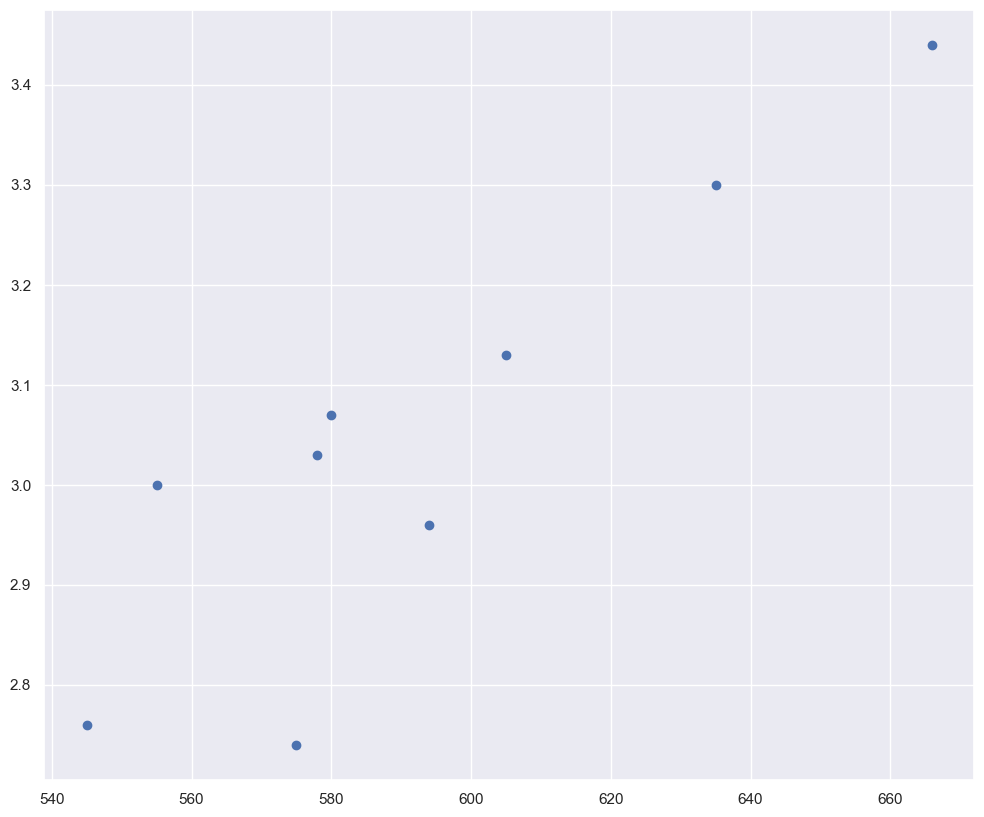

In [54]:
plt.scatter(df_t_9['LSAT'],df_t_9['GPA'])

In [55]:
df_t_9 = df_t_9.reset_index(drop=True)

In [56]:
df_t_9

,LSAT,GPA
0,635,3.30
1,578,3.03
2,666,3.44
3,580,3.07
4,555,3.00
5,605,3.13
6,575,2.74
7,545,2.76
8,594,2.96


In [57]:
l_9 = [0,1,2,3,4,5,6,7,8]
combinations_9 = list(itertools.combinations_with_replacement(l_9,9))

In [58]:
type(list(combinations_9[5698]))

list

In [59]:
ls_9 = list(combinations_9[0])
print(ls_9)
sample_9 = df_t_9.iloc[ls_9]
sample_9

[0, 0, 0, 0, 0, 0, 0, 0, 0]


,LSAT,GPA
0,635,3.3
0,635,3.3
0,635,3.3
0,635,3.3
0,635,3.3
0,635,3.3
0,635,3.3
0,635,3.3
0,635,3.3


In [60]:
len(combinations_9) ### sanity check for n=9: (2n-1)C(n-1) = 17C8 = 24310

24310

In [61]:
index_9 = np.arange(len(combinations_9))
type(index_9)

numpy.ndarray

In [62]:
index_9 = index_9.tolist()
print(type(index_9))

<class 'list'>


In [63]:
start = time.time()

complete_r_9 = []

for k, i in zip(combinations_9, index_9):
    ls_9 = list(k)
    sample_9 = df_t_9.iloc[ls_9].to_numpy()
    temp_r_9, _ = pearsonr(sample_9[:,0], sample_9[:,1])
    complete_r_9.append(temp_r_9) 
    if (i%10000 ==0): ### print every 10000 samples to see progress
        print(i)
                    

end = time.time()

print(end-start) ### seconds to run this cell

C:\Users\Uni\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


0
10000
20000
31.83565855026245


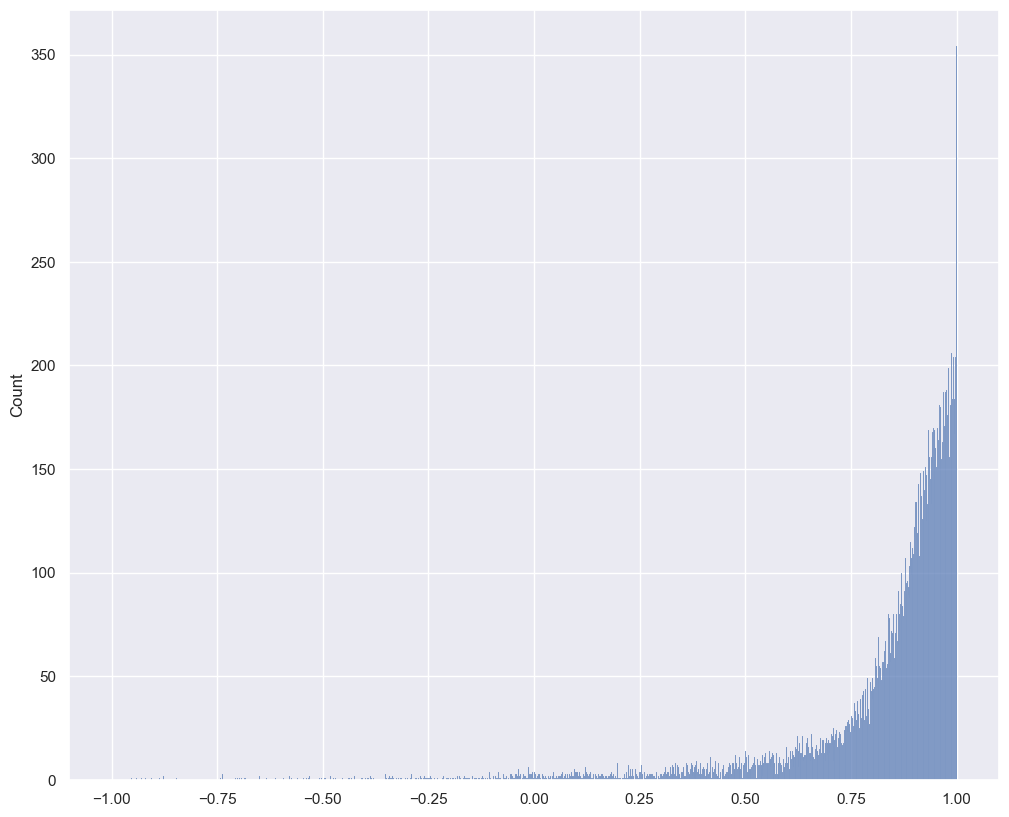

In [64]:
sns.set(rc={"figure.figsize":(12,10)})
sns.histplot(complete_r_9, binwidth=0.0013)
plt.show()

In [65]:
np.nanmean(complete_r_9)

0.8308121309472771

# Below is the code where we tried to run some parallel computations, but unfortunately they did not work. Nevertheless, we present this code

# Multiprocessing module

In [19]:
boot_sample = A[np.random.choice(A.shape[0], 15, replace=True)]
boot_sample.shape

(15, 2)

In [20]:
print(boot_sample)

[[605.     3.13]
 [653.     3.12]
 [580.     3.07]
 [575.     2.74]
 [558.     2.81]
 [605.     3.13]
 [576.     3.39]
 [651.     3.36]
 [594.     2.96]
 [666.     3.44]
 [653.     3.12]
 [651.     3.36]
 [572.     2.88]
 [576.     3.39]
 [653.     3.12]]


In [38]:
start = time.time()
num_boots = 700000
boot_samples = [] ### array to iterate over
for i in range(num_boots):
    boot_samples.append(A[np.random.choice(A.shape[0], 15, replace=True)])
    
end = time.time()

print(end-start)

25.19264030456543


In [22]:
boot_samples[0][:,0]

array([661., 575., 651., 661., 572., 605., 651., 661., 605., 555., 666.,
       651., 635., 575., 578.])

In [23]:
### define boot function with iterator i

boot_r = []
boot_p_val=[]
boot_sample = A[np.random.choice(A.shape[0], 15, replace=True)]
def boot(i):
    boot_r_temp, boot_p_val_temp = pearsonr(boot_samples[i][:,0],boot_samples[i][:,1])
    boot_r.append(boot_r_temp)
    boot_p_val.append(boot_p_val_temp)
    return(boot_r)


In [24]:
boot_samples[0]

array([[661.  ,   3.43],
       [575.  ,   2.74],
       [651.  ,   3.36],
       [661.  ,   3.43],
       [572.  ,   2.88],
       [605.  ,   3.13],
       [651.  ,   3.36],
       [661.  ,   3.43],
       [605.  ,   3.13],
       [555.  ,   3.  ],
       [666.  ,   3.44],
       [651.  ,   3.36],
       [635.  ,   3.3 ],
       [575.  ,   2.74],
       [578.  ,   3.03]])

In [39]:
### define boot function with iterator sample_boots

boot_r = []
boot_p_val=[]
boot_sample = A[np.random.choice(A.shape[0], 15, replace=True)]
def boot(sample):
    boot_r_temp, boot_p_val_temp = pearsonr(sample[:,0],sample[:,1])
    boot_r.append(boot_r_temp)
    boot_p_val.append(boot_p_val_temp)
    return(boot_r)


In [92]:
start = time.time()
n_cores = 8
if __name__ == '__main__':
    pool = Pool(n_cores)                         # Create a multiprocessing Pool
    pool.apply_async(boot, boot_samples)
    
end = time.time()
print(f"The time to run the bootstrap parallel number of samples was: {end-start} seconds ")    

The time to run the bootstrap parallel number of samples was: 0.03555798530578613 seconds 


In [95]:
len(boot_samples)

40000

In [96]:
boot_r

[]

In [ ]:
pool = Pool(8)
for _ in tqdm.tqdm(pool.imap_unordered(boot, boot_samples), total=len(boot_samples)):
    pass

  0%|          | 0/40000 [00:00<?, ?it/s]

In [65]:
for i in range(100):
    boot(boot_samples[i])

# Asyncio

In [40]:
import asyncio
boot_r = []
boot_p_val=[]

def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)

    return wrapped

@background
def boot(sample):
    boot_r_temp, boot_p_val_temp = pearsonr(sample[:,0],sample[:,1])
    boot_r.append(boot_r_temp)
    boot_p_val.append(boot_p_val_temp)
    return(boot_r)

start = time.time()
for sample in boot_samples:
    boot(sample)
    
end = time.time()

print(end-start)

928.6929235458374


In [26]:
start = time.time()
if __name__ == '__main__':
    p = Process(target=boot, args=(i,)) for i in range(2000)
    p.start()
    p.join()
    
end = time.time()
print(f"The time to run the bootstrap for {n_resamples} number of samples was: {end-start} seconds ")


SyntaxError: invalid syntax (2260495966.py, line 3)

In [17]:
boot_r = boot(4000)

In [18]:
len(boot_r)

4000

In [ ]:
start = time.time()
Parallel(n_jobs=10, verbose=10)(delayed(boot)(i) for i in range(0,1000))
end = time.time()

print(f"The time to run the bootstrap for 4000000 number of samples was: {end-start} seconds ")


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   14.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   24.5s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   34.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   47.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   59.9s


In [21]:
start = time.time()

boot_r_withfunc = boot(40000)

end = time.time()

end-start

45.81954622268677

In [17]:
A[:,1]

array([3.39, 3.3 , 2.81, 3.03, 3.44, 3.07, 3.  , 3.43, 3.36, 3.13, 3.12,
       2.74, 2.76, 2.88, 2.96])

In [22]:
permutations = itertools.permutations(A)

In [23]:
permutations[5]

TypeError: 'itertools.permutations' object is not subscriptable

In [28]:
a = GrayCode(10)

In [29]:
type(a)

sympy.combinatorics.graycode.GrayCode

In [30]:
len(list(a.generate_gray()))

1024

In [25]:
list(a.generate_gray())

['000000000000000',
 '000000000000001',
 '000000000000011',
 '000000000000010',
 '000000000000110',
 '000000000000111',
 '000000000000101',
 '000000000000100',
 '000000000001100',
 '000000000001101',
 '000000000001111',
 '000000000001110',
 '000000000001010',
 '000000000001011',
 '000000000001001',
 '000000000001000',
 '000000000011000',
 '000000000011001',
 '000000000011011',
 '000000000011010',
 '000000000011110',
 '000000000011111',
 '000000000011101',
 '000000000011100',
 '000000000010100',
 '000000000010101',
 '000000000010111',
 '000000000010110',
 '000000000010010',
 '000000000010011',
 '000000000010001',
 '000000000010000',
 '000000000110000',
 '000000000110001',
 '000000000110011',
 '000000000110010',
 '000000000110110',
 '000000000110111',
 '000000000110101',
 '000000000110100',
 '000000000111100',
 '000000000111101',
 '000000000111111',
 '000000000111110',
 '000000000111010',
 '000000000111011',
 '000000000111001',
 '000000000111000',
 '000000000101000',
 '000000000101001',


In [22]:
l = [1,2,3,4,5,6,7,8,9,10,11]
combinations = list(itertools.combinations_with_replacement(l,11))

In [23]:
len(list(combinations))

352716